**Deep Learning:** Deep learning is a subset of machine learning using artificial neural networks to model and solve complex tasks like image recognition, natural language processing, and predictions, mimicking human decision-making through hierarchical feature learning.

**CNN:** A Convolutional Neural Network (CNN) is a type of deep learning model designed for processing grid-like data, such as images. It uses convolutional layers to automatically extract spatial features, pooling layers for dimensionality reduction, and fully connected layers for classification or regression tasks. CNNs excel in image recognition and object detection.

**Importance of Explainability in Deep Learning:** Explainability in deep learning refers to the ability to understand and interpret how a model makes its predictions. It's crucial for building trust, ensuring transparency, and identifying potential biases in models. In sensitive areas like healthcare, finance, or law, explainability helps stakeholders make informed decisions and ensures that the model's behavior aligns with ethical standards and regulatory requirements.

**Attention Mechanism:** An attention mechanism in deep learning is a technique that allows models to focus on specific parts of input data, assigning varying importance to different elements. It enhances performance by prioritizing relevant features, particularly in sequence-based tasks like natural language processing, image captioning, and speech recognition, enabling better context understanding and improved predictions.

**CNN With Attention mechanism:**
A Convolutional Neural Network (CNN) with Attention Mechanism combines the powerful feature extraction capabilities of CNNs with the ability of attention mechanisms to prioritize important regions or features in input data. While CNNs excel at learning spatial hierarchies in images, they treat all features equally within a receptive field. The attention mechanism addresses this by dynamically weighting the relevance of different features or regions, enabling the model to focus on the most critical areas.

**Key Features:**

**Feature Extraction:** CNN layers extract spatial features from images or other structured data.

**Attention Module:** An attention module (e.g., spatial or channel-wise attention) highlights the most informative parts of these features.

**Enhanced Understanding:** The integration improves performance, especially in complex tasks requiring nuanced decision-making like image recognition, object detection, or medical image analysis.

This combination results in more robust, interpretable, and accurate models.

**Grad-CAM:** Gradient-weighted Class Activation Mapping (Grad-CAM) is a visualization technique that highlights regions in an input image contributing most to a model's prediction. It uses gradients from the final convolutional layer to generate heatmaps, providing interpretability by showing which areas influenced the decision, making deep learning models more transparent and explainable.

**Steps associated with Grad-CAM:**

**Forward pass:** The image is passed through the model, and we compute the class score for a target class.

**Backward pass:** The gradient with respect to the class score is computed and backpropagated.

**Activation and Gradient Handling:** We pool the gradients across all channels of the last convolutional layer. These pooled gradients are used to weight the activations, producing a heatmap that highlights important areas in the image.

**Normalization:** The heatmap is normalized to the range [0, 1] and resized to match the input image dimensions.

**Importance of Grad-CAM heatmap:** The Grad-CAM heatmap is applied to the image to visualize important regions for the target class prediction. A color overlay is used to enhance the visibility of the regions of interest. The output will be a visualization of the image with the Grad-CAM heatmap superimposed on top of it. The regions of the image that contribute most to the model's prediction will be highlighted in warmer colors (e.g., red and yellow).

**CIFAR-10 dataset description:** The CIFAR-10 dataset is a collection of 60,000 32x32 color images across 10 categories. The 10 categories in the CIFAR-10 dataset are: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship and Truck. It is widely used for training machine learning models in image classification tasks, with 50,000 training and 10,000 test images.

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


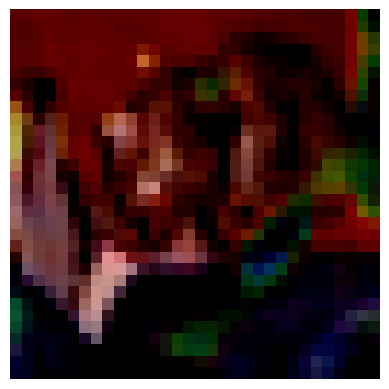

In [1]:
import torch                        #Imports PyTorch, a framework for deep learning.
import torch.nn as nn               #Provides tools for building neural networks (e.g., layers, loss functions).
import torch.optim as optim         #Contains optimization algorithms like SGD and Adam.
import torchvision                  #Provides utilities for common vision datasets, models, and image transformations.
import torchvision.transforms as transforms      #Supports transformations for preprocessing image data.
import matplotlib.pyplot as plt                  #Enables plotting and visualization of results.
import numpy as np                               #For numerical operations on arrays.
import cv2                                       #Provides image processing capabilities (OpenCV).

# Define CNN Model with Attention
class CNNWithAttention(nn.Module):              #Defines a CNN with an attention mechanism.
    def __init__(self):                         #Constructor to define layers and initialize the model.
        super(CNNWithAttention, self).__init__()            #super(): Refers to the parent class of the current class (CNNWithAttention).(CNNWithAttention, self):Indicates that we are calling the parent of CNNWithAttention for the current object (self).__init__():Invokes the constructor of the parent class (nn.Module), which sets up the base functionality required for PyTorch modules.
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)         #This line creates a 2D convolutional layer, self.conv1, with 3 input channels, 64 output channels, a kernel size of 3x3, and padding of 1.
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)       #This line creates a 2D convolutional layer, self.conv2, with 64 input channels, 128 output channels, a kernel size of 3x3, and padding of 1.
        self.attention = AttentionLayer(128)                #Apply attention on the second convolutional layer
        self.fc1 = nn.Linear(128*8*8, 512)                  #This line creates a fully connected layer, `self.fc1`, mapping an input of size (128 x 8 x 8) (flattened to a 1D vector of 8192 elements) to an output of 512 features. It's used for feature transformation.
        self.fc2 = nn.Linear(512, 10)                       #Final layer mapping 512 units to 10 classes (CIFAR-10 categories)
        self.pool = nn.MaxPool2d(2, 2)                      #This line defines a 2D max pooling layer, `self.pool`, that reduces spatial dimensions by half with a 2x2 window.
        self.relu = nn.ReLU()                               #Activation function ReLU is introducing non-linearity.

        # For storing activations during the forward pass
        self.activations = None             #This line initializes the attribute, self.gradients, to None.
        self.gradients = None               #This line initializes the attribute, self.activations, to None.

        # Register hook to capture activations and gradients
        self.conv2.register_forward_hook(self.save_activation)          #Saves feature maps from conv2 during the forward pass
        self.conv2.register_backward_hook(self.save_gradient)           #Saves gradients during the backward pass.

    def save_activation(self, module, input, output):       #This defines a method `save_activation` that stores the output (activation) of a module. It takes the module, input, and output as arguments, typically used for capturing activations during forward pass for later use.
        self.activations = output                           #This assigns the output of a layer or module to the `activations` attribute for later use.

    def save_gradient(self, module, grad_input, grad_output):   #This defines a method `save_gradient` that stores the gradients during backpropagation. It takes the module, gradient inputs, and gradient outputs as arguments, typically used for capturing gradients for analysis.
        self.gradients = grad_output[0]                         #This assigns the first element of the gradient output (`grad_output[0]`) to the `gradients` attribute, typically storing the gradients of the layer's output for later use in analysis.

    def forward(self, x):                                   #This defines the forward pass method, `forward`, that processes input `x` through the network layers.
        x = self.pool(self.relu(self.conv1(x)))             #This line applies a series of transformations to the input `x`: first, a convolution (`self.conv1`), then a ReLU activation (`self.relu`), followed by a max pooling operation (`self.pool`), which reduces the spatial dimensions of the output.
        x = self.pool(self.relu(self.conv2(x)))             #This line applies a series of transformations to the input `x`: first, a convolution (`self.conv2`), then a ReLU activation (`self.relu`), followed by a max pooling operation (`self.pool`), which reduces the spatial dimensions of the output.
        x = self.attention(x)  # Apply attention after convolution
        x = x.view(-1, 128*8*8)  #This line reshapes the tensor `x` into a 2D tensor with a size of (-1) (automatically determined based on the batch size) and (128 x 8 x 8) features, flattening the spatial dimensions into a single vector per sample.
        x = self.relu(self.fc1(x))   #This line applies a fully connected layer (`self.fc1`) to the input `x`, followed by a ReLU activation function (`self.relu`). It transforms `x` through a linear transformation and then introduces non-linearity with ReLU.
        x = self.fc2(x)   #This line applies a second fully connected layer (`self.fc2`) to the input `x`, performing a linear transformation that outputs a new tensor, typically for producing the final predictions or feature representation.
        return x          #The return x statement outputs the tensor x from the function


# Define Attention Layer (for simplicity)
class AttentionLayer(nn.Module):      #Defines a class `AttentionLayer` that inherits from PyTorch's `nn.Module`, used for building neural networks.
    def __init__(self, in_channels):  #Defines the initialization method for a class, taking `in_channels` as an input parameter.
        super(AttentionLayer, self).__init__()    #This line initializes the parent class (`AttentionLayer`) using Python's `super()`, ensuring the base class's constructor runs properly.
        self.attention_weights = nn.Parameter(torch.randn(1, in_channels, 1, 1))  #The shape (1, in_channels, 1, 1) means one set of weights per input channel, shared across spatial dimensions, useful in channel-wise attention mechanisms. nn.Parameter makes it trainable during backpropagation.

    def forward(self, x):    #defines the forward pass function of a model, specifying how input x is processed through the network.
        attention_map = torch.sigmoid(self.attention_weights)  #applies the sigmoid activation function to attention_weights, producing values between 0 and 1, representing the attention map.
        return x * attention_map  #apply attention map to input


# Grad-CAM Function
def generate_gradcam(model, input_image, target_class):     #defines a function that generates Grad-CAM visualizations for a given model, input image, and target class.
    model.eval()   #sets the model to evaluation mode, disabling behaviors like dropout and batch normalization.
    input_image = input_image.unsqueeze(0)  #adds an extra dimension to `input_image`, typically for batch processing in neural networks.
    input_image.requires_grad_()  #enable gradient calculation

    # Forward pass
    output = model(input_image)  #passes the input_image through the model to generate predictions.

    # Zero all gradients
    model.zero_grad()

    # Backpropagate to get gradients w.r.t the target class
    target = output[0][target_class]     #extracts the value from the output tensor corresponding to the target_class index.
    target.backward()      #computes the gradients of the target tensor with respect to the model's parameters using backpropagation.

    # Get the gradient of the last convolutional layer
    gradients = model.gradients            #assign the model's stored gradient to the variables gradients
    activations = model.activations        #assign the model's stored activation values to the variables activations

    # Pool the gradients across all the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])  #The line `pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])` computes the mean of the `gradients` tensor across dimensions 0, 2, and 3, effectively averaging the gradients over the batch, height, and width of the data.

    # Weight the activations by the gradients
    for i in range(activations.shape[1]):    #starts a loop that iterates over the second dimension of the activations tensor, typically representing the number of channels in the data.
        activations[:, i, :, :] *= pooled_gradients[i]  #The line `activations[:, i, :, :] *= pooled_gradients[i]` multiplies each channel of the `activations` tensor (indexed by `i`) by the corresponding value in `pooled_gradients[i]`, scaling the activations based on the gradient values for each channel.

    # Take the average of the weighted activations
    heatmap = torch.mean(activations, dim=1).squeeze()  #computes the mean of the activations tensor along dimension 1 (usually the channel dimension), then removes any singleton dimensions with .squeeze(), resulting in a simplified heatmap.

    # Normalize the heatmap
    heatmap = np.maximum(heatmap.detach().numpy(), 0)       #This line converts the heatmap tensor to a NumPy array, detaching it from the computation graph and ensuring all values are non-negative by applying np.maximum to set any negative values to zero.
    heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[3]))  #resizes the heatmap to match the spatial dimensions (width and height) of the input image. Specifically, input_image.shape[2] and input_image.shape[3] represent the width and height of the input_image. The cv2.resize() function adjusts the heatmap to have the same dimensions as the input image, which is typically necessary when overlaying or comparing the heatmap with the original image in tasks like visualization or analysis.
    heatmap = heatmap / heatmap.max()  #normalizes the heatmap by dividing each value in the heatmap by the maximum value in the heatmap. This scales the values so that the highest value becomes 1, and all other values fall between 0 and 1.

    return heatmap   #The normalized heatmap is then returned, ensuring a consistent range of values for further processing or visualization.


# Visualization function
def display_gradcam(image, heatmap):          #This defines a function `display_gradcam` that takes an image and a heatmap as inputs to visualize the Grad-CAM result.
    image = image.numpy().transpose(1, 2, 0)       #This line converts the image tensor to a NumPy array using .numpy(). The .transpose(1, 2, 0) rearranges the dimensions of the image from (channels, height, width) to (height, width, channels), which is the standard format for displaying images in libraries like Matplotlib.
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)        #This line scales the heatmap to 8-bit integer values (0–255), applies the JET colormap from OpenCV, and creates a colorized heatmap for visualization.
    heatmap = np.float32(heatmap) / 255                                      #This line normalizes the heatmap values by converting them to float32 data type and scaling them to the range [0, 1].
    overlayed_image = 0.4 * heatmap + 0.6 * image                            #Combines heatmap and original image.
    plt.imshow(overlayed_image)                                              #Displays the overlay.
    plt.axis('off')                           #Turn off the axis labels
    plt.show()                                #Display the plotted image using Matplotlib, ensuring a cleaner, distraction-free visualization.


# Example usage
if __name__ == '__main__':           #This line ensures that the code block below it runs only when the script is executed directly, not imported as a module.
    # Load CIFAR-10 dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   #transforms.ToTensor() converts image data from a PIL Image or NumPy array into a PyTorch tensor, scaling pixel values to the range [0, 1]. transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) standardizes the pixel values for all three RGB channels by subtracting the mean 0.5 and dividing by the standard deviation 0.5. This centers the data around zero with a range [-1, 1].
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)            #This line initializes the CIFAR-10 test dataset. It stores data in the `./data` directory, disables training mode, downloads the dataset if unavailable, and applies the specified `transform` preprocessing pipeline.
    testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)                                    #This line creates a DataLoader for the testset, loading data in batches of 4 without shuffling.

    # Initialize model and load the first image from the test set
    model_with_attention = CNNWithAttention()   #The instantiated object model_with_attention represents the CNN model and contains all the layers, operations, and hooks defined in the CNNWithAttention class.
    sample_image, label = testset[0]  # Get first image and label
    target_class = label  # Use the class label of the image

    # Generate Grad-CAM heatmap
    heatmap = generate_gradcam(model_with_attention, sample_image, target_class)

    # Display the image with Grad-CAM overlay
    display_gradcam(sample_image, heatmap)

The red and yellow regions represent areas of the image where the deep learning model focuses most strongly to make its prediction. These regions have the highest activations and are considered the most influential for the model's decision-making.
The green and blue areas are less influential, indicating lower activation values.
